## Chapter 14: Tree-based learners

# 14.2 Regression Trees

In this Section we discuss the use of tree-based units for the problem of regression, often called *regression trees*.  Unlike kernel or neural network universal approximators, cost functions imbued with tree-based units create highly non-convex and often flat staircase-like cost functions that cannot be optimized directly via any local method.  Instead, trees must be fit to regression (and classification) data *recursively* in a heuristic manner.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
 
# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# plotting
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

## 14.2.1  Regression Stumps

Suppose we take a simple nonlinear regression dataset $\left\{x_p,y_p\right\}_{p=1}^P$ like the one shown in the top left panel of the Figure below and try to fit a nonlinear regressor to it using a model composed of a single stump, which has three parameters: the location of the stump's split-point as well as its two leaf values.  However if we try to properly tune these parameters by minimizing an appropiate cost function over the model (e.g., the Least Squares) we will find hat the resulting cost function is very difficult to minimize.  Not only is such a cost function non-convex, but it consists of staircase like sections containing completely flat regions that no local optimization algorithm can navigate effectively (we saw similar behavior when dealing with step functions in the context of logistic regression back in Sections 6.1 - 6.2).  The problematic parameter producing this effect is always the *split-point*, regardless of how the leaf values are set. 

### Determining proper split-points

We illustrate this by visualizing *three one-dimensional slices* of the full three-dimensional Least Squares cost function over this dataset and the split-point parameter alone, each slice provided by a stump with distinct *fixed leaf values* (the stumps are plotted in the top-right panel of the Figure).  With the leaf values of each stump fixed only the split-point parameter of each stump remains to be optimally tuned, and hence its Least Squares cost is *one-dimensional*.  In other words, we take each stump shown in the top-right panel of the Figure and sweep it over the dataset horizontally, tryinng out all possible split-points for each in the input space of the dataset, and plot the corresponding cost functions.  These costs are plotted in the middle-left panel of the Figure, and are colored to match their corresponding stumps shown in the top-right panel (e.g., the red cost corresponds to the red stump, the blue cost the blue stump, and the green cost the green stump).  Each cost, as we can see, looks like a staircase consisting of perfectly flat regions. 

<IPython.core.display.Javascript object>


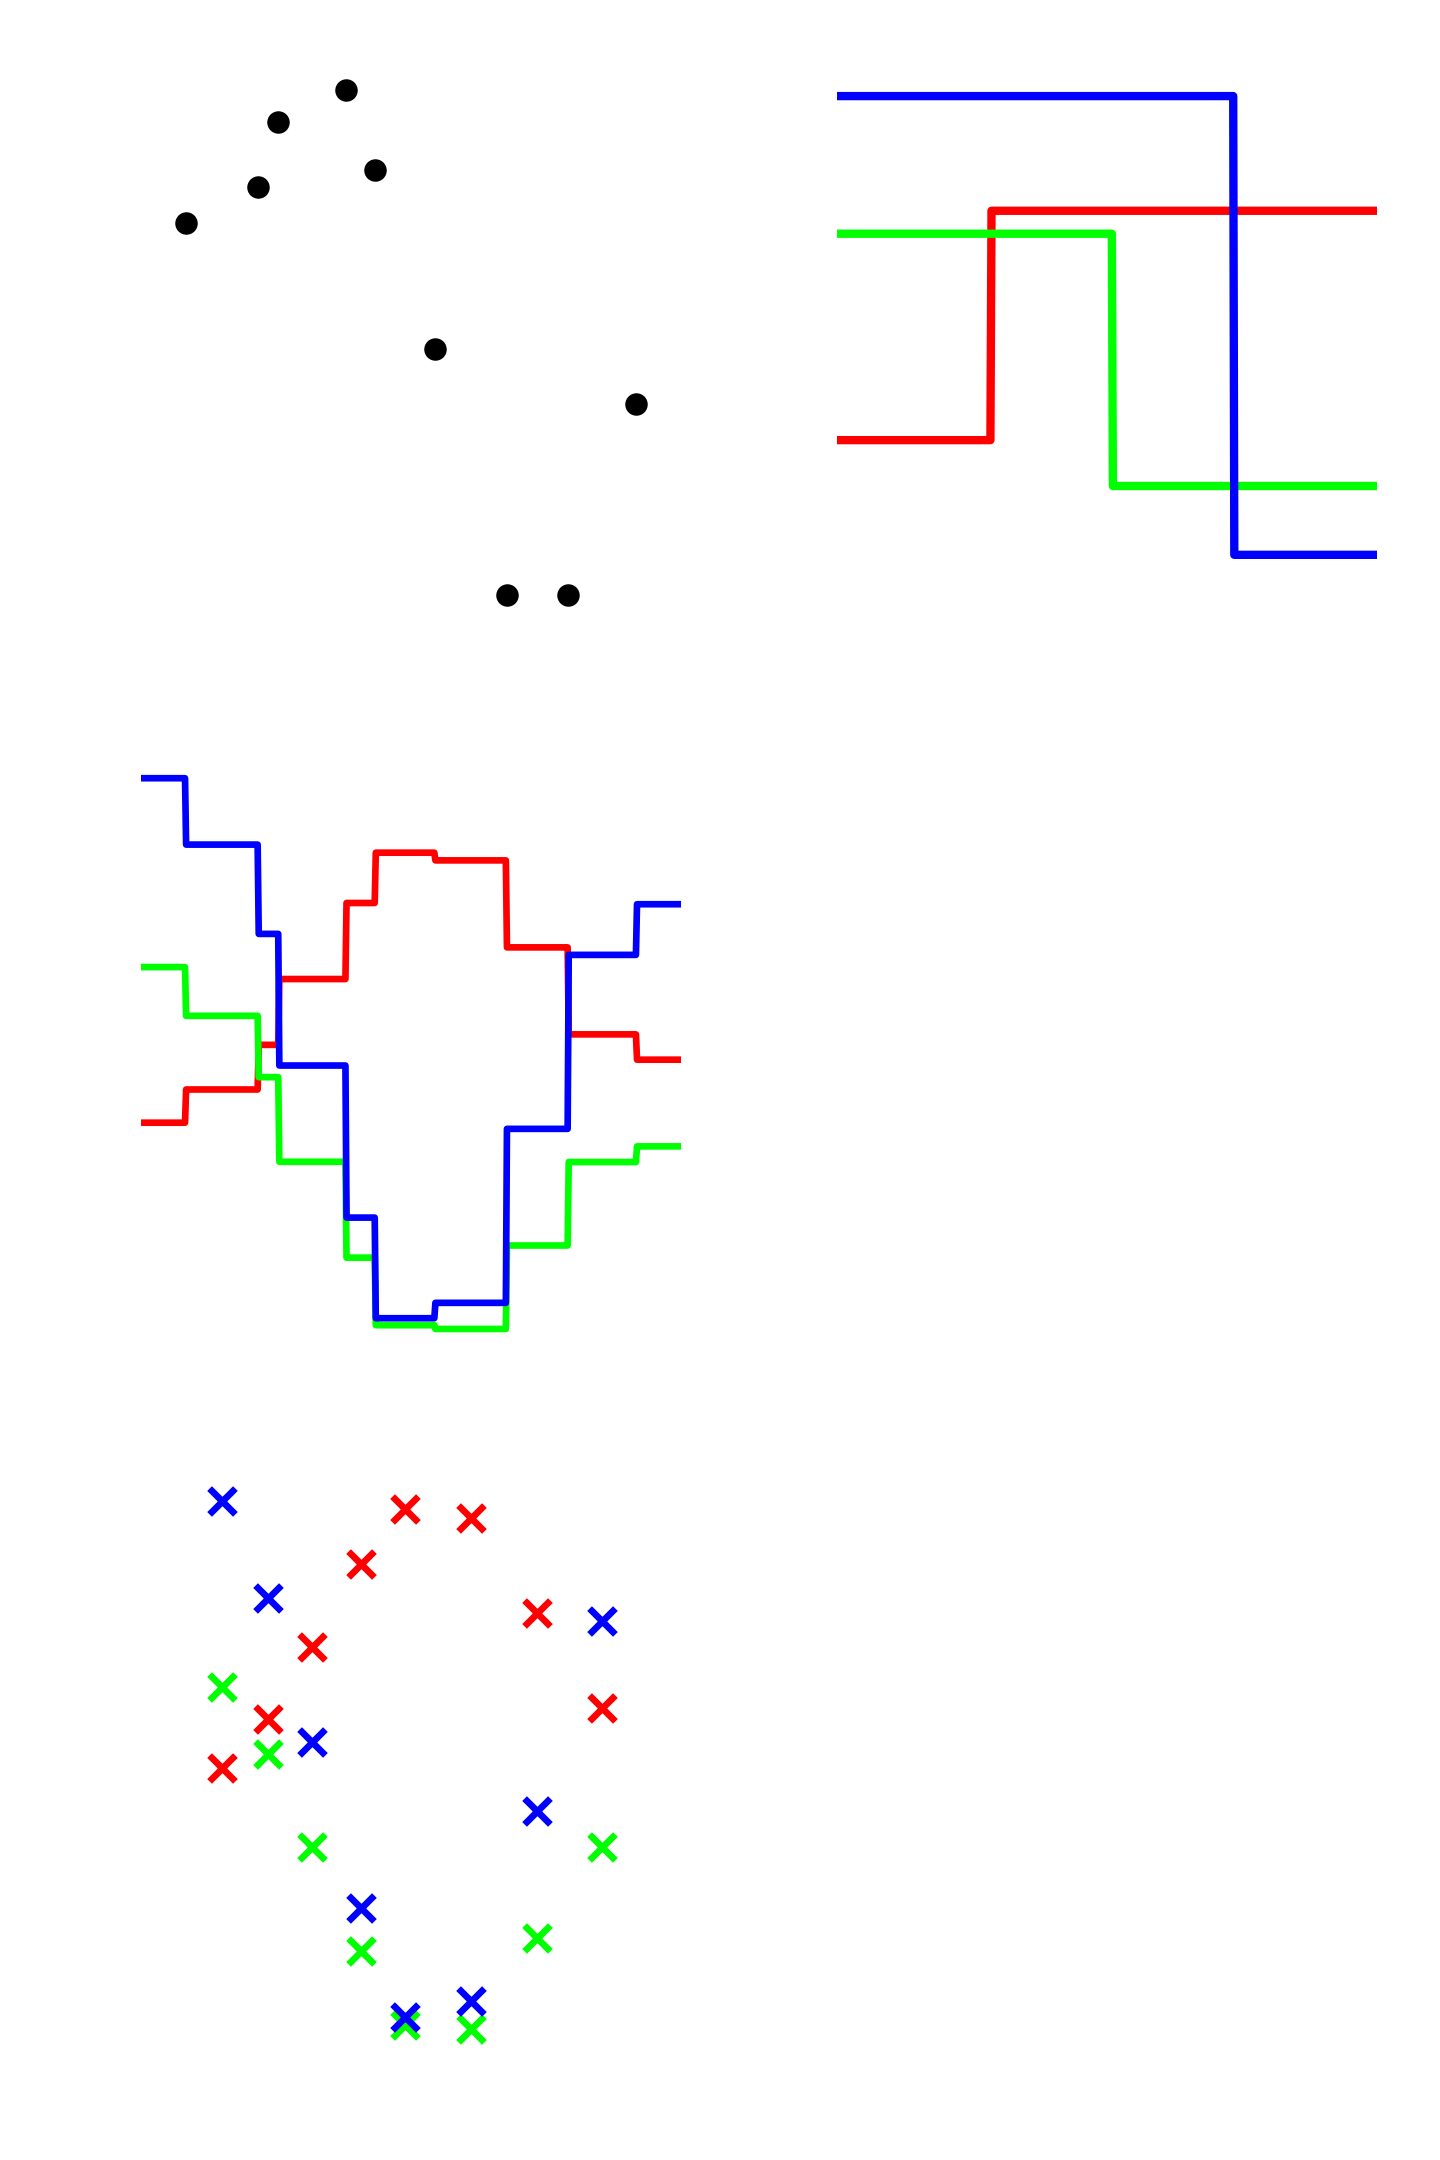

In [37]:
## This code cell will not be shown in the HTML version of this notebook
csvname = datapath + 'noisy_sin_subsample_2.csv'
demo = nonlib.regression_tree_demo.Visualizer(csvname)
demo.multistump_plotter()

These flat regions exist because the shape of our nonlinearity - the stump.  Since it consists of two constant values (its leaves), when those values are fixed the corresponding Least Squares cost *stays at the exact same level when the split-point lies in-between the input of any two datapoints*.  This means that - regardless of the values of a stump's leaves - its corresponding cost value will always *remain constant for split-point values in-between consecutive inputs*.  We can see this for the case of our three stumps in the middle-left panel below.  While all three costs take on a staircase shape, their flat areas are always located in the same locations: the regions in-between consecutive input values. 

This fact has a very practical reprocussion, since while we cannot properly tune the split-point of a stump using local optimization (due to the staircase shape of the cost function over this parameter) we can find one by simply *testing a single value in each of the flat areas of the cost*.  We certainly do not need to test more than one value per flat region, since all split-points in such an area provide the *exact same cost value*.  Moreover, we can always very easily find one candidate split-point per flat region since we need only take a point in-between each successive pair of inputs of our dataset, like for example the *midpoint* $\frac{x_{p+1} - x_{p}}{2}$ for $p=0,...,P-1$.  The cost function for each of our three example stumps evaluated over these midpoints are illustrated in the lower-left panel of the Figure.

### Determining optimal leaf values for a fixed split-point

Contrary to the task of determining the optimal split-point of a stump with fixed leaf values, to determine the optimal leaf values for a stump with a *fixed split-point* is exceedingly straightforward.  Since the leaves are *constant valued*, and we are using the stump as a nonlinear regressor, it makes intuitive sense to simply set the value of each leaf *to the mean of the points it will represent*.  This is illustrated in the Figure below, where for a given split-point (illustrated by the vertical blue dashed line shown in the left panel) the leaf value on the *left* is set to the *mean of those points lying to the left of the split point*, and the leaf value on the right is set to the *mean of those points to the right of the split-point*.  The stump formed by this choice is shown in red in the middle panel of the Figure. 

Moreover, unlike the case above where we aimed to minimize a Least Squares over the split-point parameter here we can in fact properly minimize a Least Squares over the two leaf values.  Indeed these intuitive choices for leaf values can be determined mechanically by minimizing the Least Squares cost employing a single stump model with fixed split-point.  This minimization is quite simple, the corresponding (two-input) cost function being *convex*.  In the right panel of the Figure we plot the cost surface corresponding to the particular stump shown in the middle panel, with its minimum highlighted by a red point.

<IPython.core.display.Javascript object>


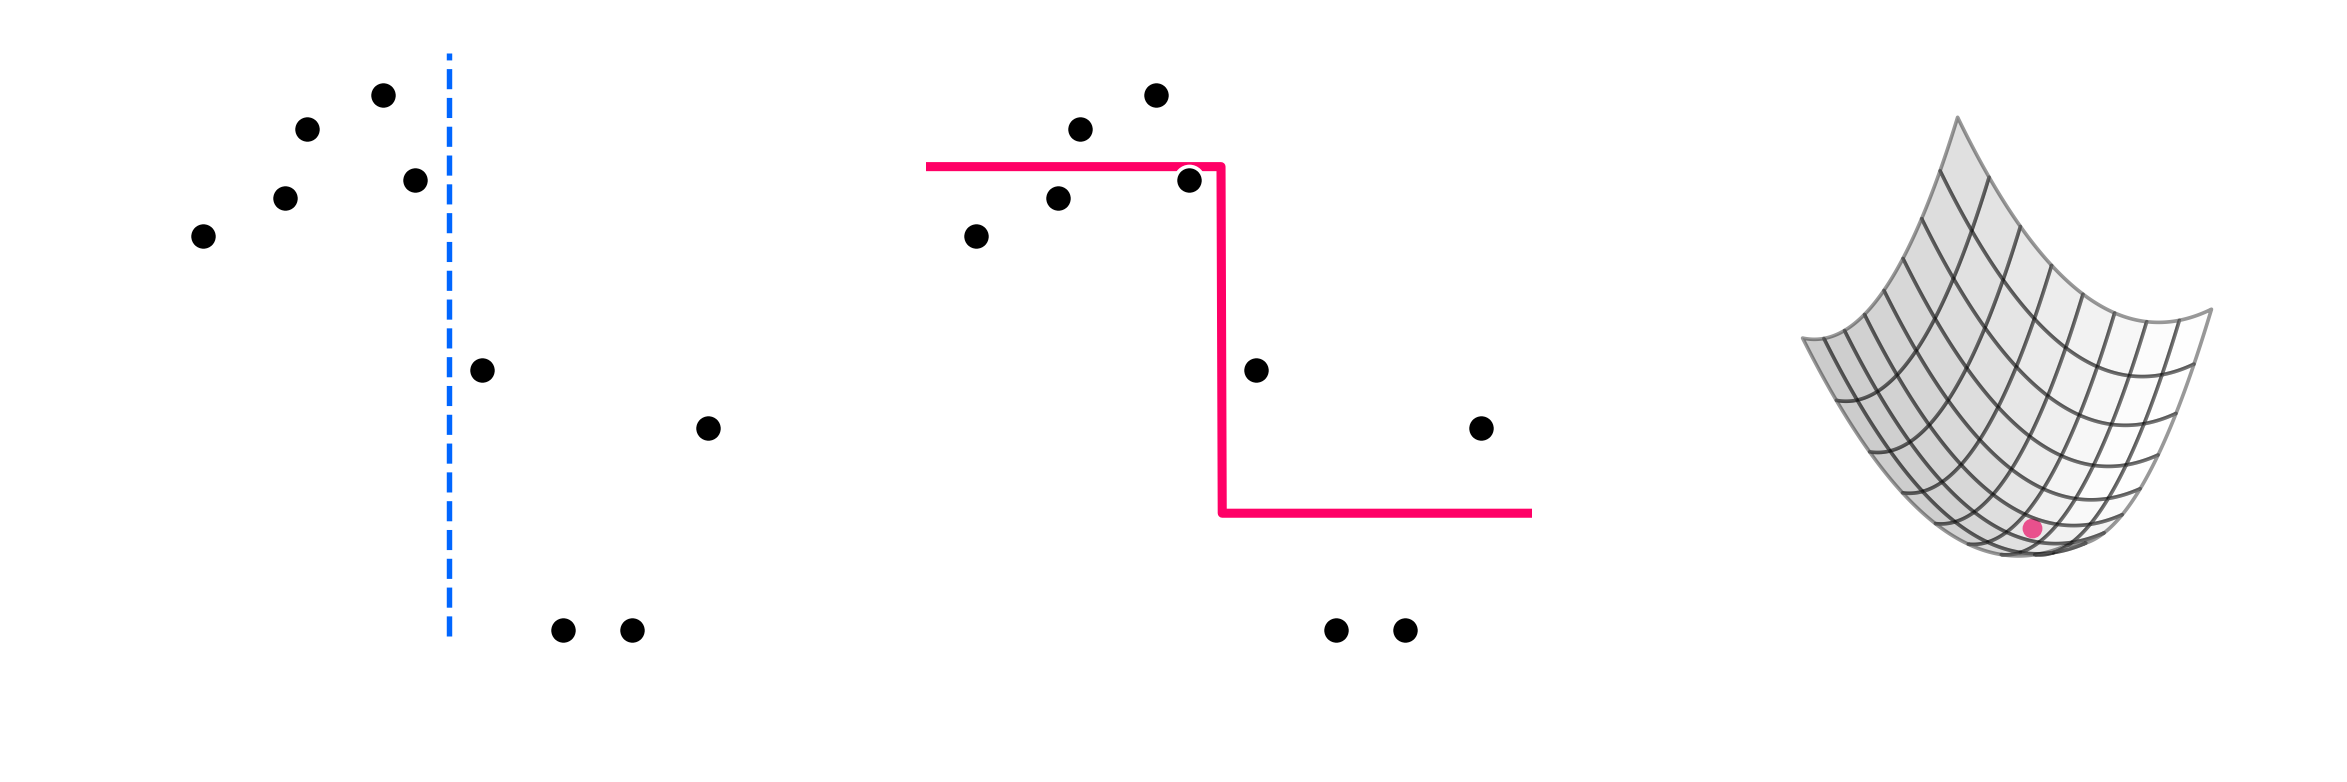

In [36]:
## This code cell will not be shown in the HTML version of this notebook
csvname = datapath + 'noisy_sin_subsample_2.csv'
demo = nonlib.regression_tree_demo.Visualizer(csvname)
demo.best_plotter()

Algebraically speaking, in general can set the leaf values of a stump $f$ with split-point $s$ defined along $n^{th}$ dimension of a dataset of $P$ points' input as

\begin{equation}
f\left(\mathbf{x}\right) = 
\begin{cases}
\frac{1}{\vert \Omega_L \vert }\sum_{p \in \Omega_L}x_{p,n}    \,\,\,\,\,\, \text{if} \,\,\,\,\, x_n \leq s \\
\frac{1}{\vert \Omega_R \vert}\sum_{p \in \Omega_R}x_{p,n} \,\,\,\,\,\, \text{if} \,\,\,\,\,  x_n > s
\end{cases}
\end{equation}

where $\Omega_L$ and $\Omega_R$ are index sets containing those points from the training set whose $n^{th}$ dimension is less than / equal to or greater than the split point value respectively in other words

\begin{array}
\
\Omega_L = \left\{\mathbf{x})_p \vert x_{p,n} \leq s  \right\} \\
\Omega_R = \left\{\mathbf{x})_p \vert x_{p,n} > s  \right\}. \\
\end{array}

### Determining optimal split-point and leaf values

Combining the two ideas above provides a reasonable work-around way for tuning all three paramters of a stump to a regression dataset (as an alternative to tuning all three together via local optimization, which we cannot do) regardless of the dataset's input dimension.  We first create a set of candidate split-point values by recording every mid-point between our input data, along each of its dimensions.  For each candidate split-point we determine the optimal stump, whose leaf values are set to the average of the training data output to the left and right of the split, and compute its (Least Squares) cost value.  After doing this for all candidate split points we keep the one that provides the *lowest* cost value.  

This idea is illustrated in below for the simple single-input regression dataset used above.  As the slider is moved from left to right the optimal stump is fit using each midpoint as a candidate split point.  Once all candidates have been tested - when the slider mechanism is all the way to the right - the particular stump providing the lowest possible cost value is kept.  In doing this we have indeed determined the parameters of the optimal stump to represent this dataset.  More generally for multi-input such split-points are formed and tested *along each input dimension*, with the particular split / leaf values providing the lowest cost value being the optimal choice.  When computation becomes a primary concern (mainly with large datasets) subsampling strategies derived from this basic sceheme are used - like e.g., testing split-points along only a random selection of all input dimensions, testing a coarser selection of split-points, etc.,


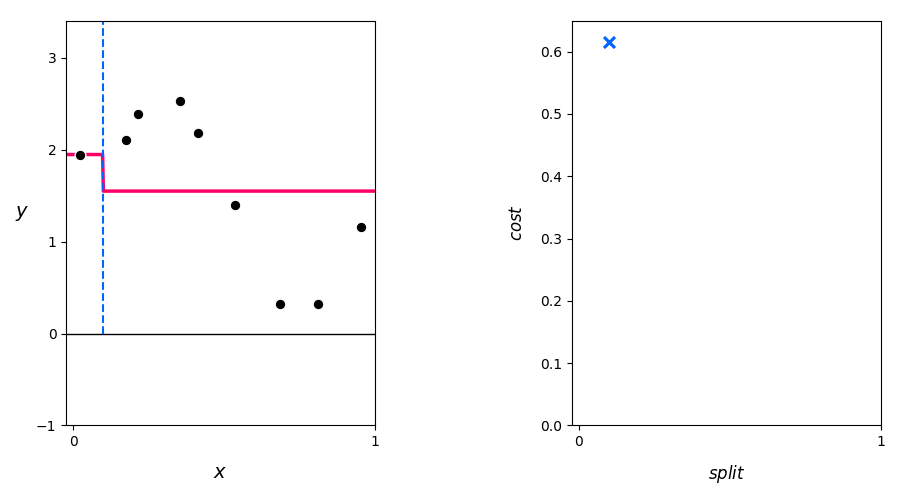
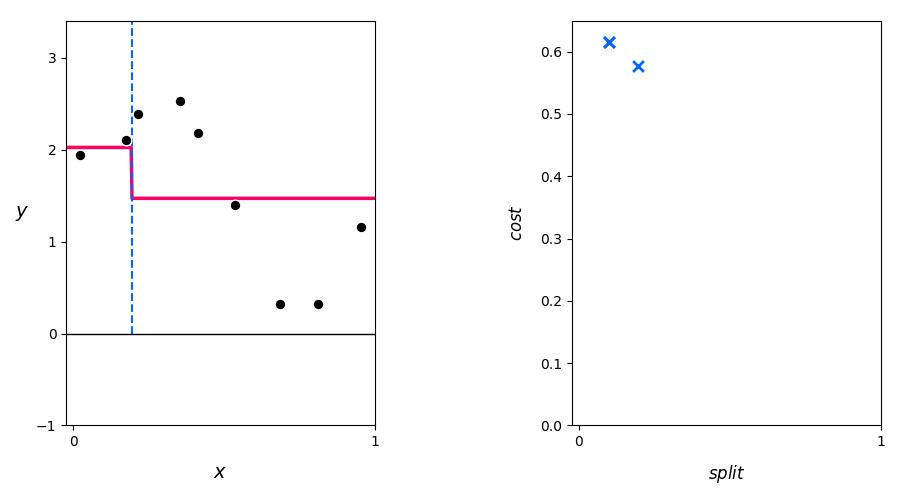
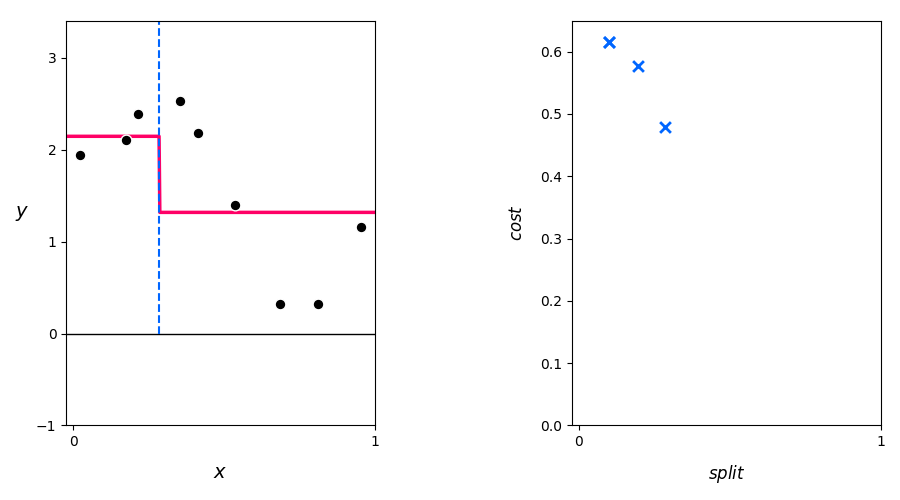
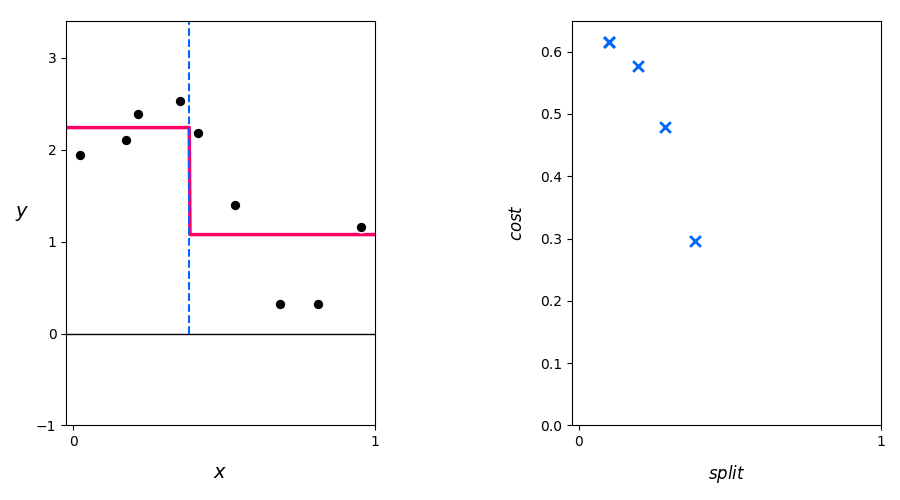
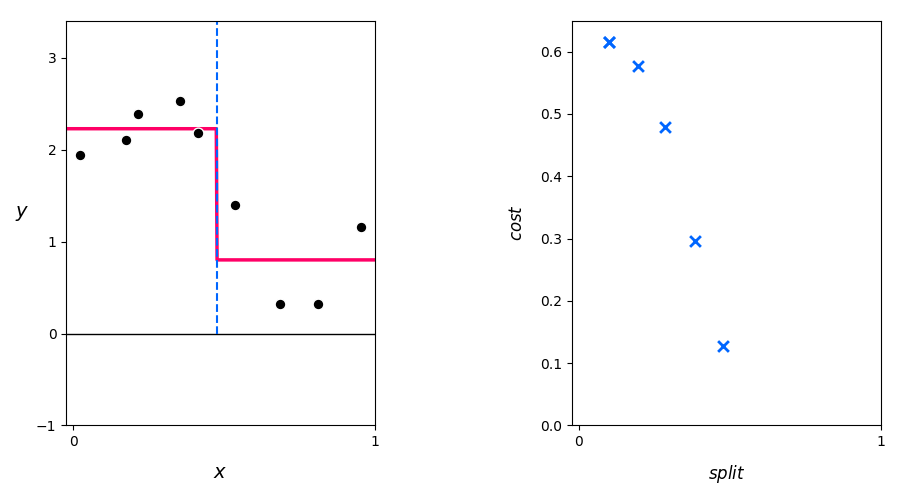
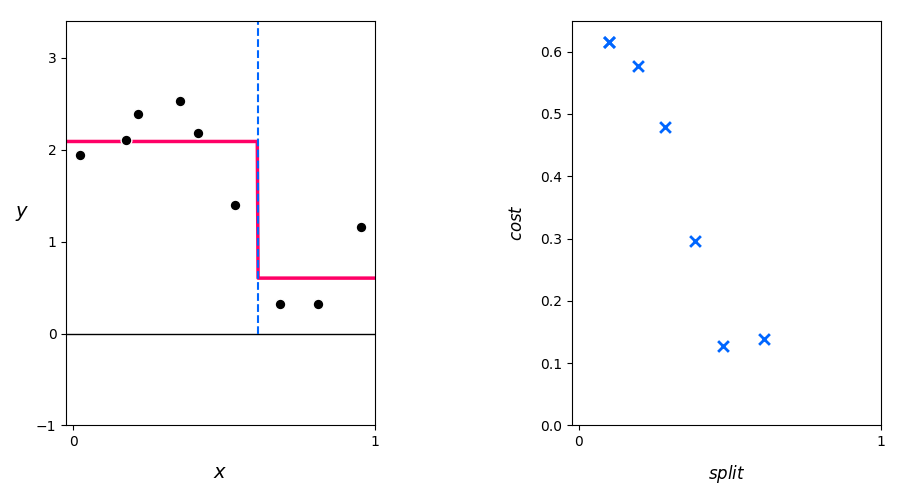
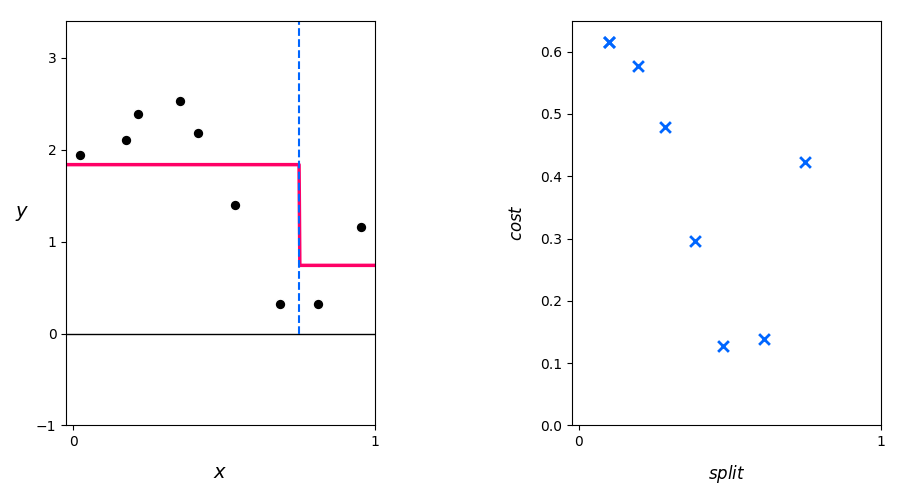
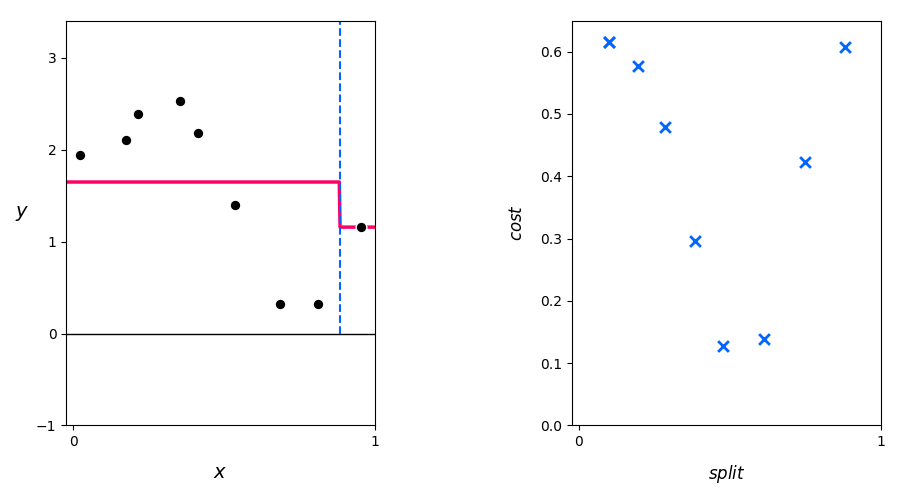

In [35]:
## This code cell will not be shown in the HTML version of this notebook
# animate stump collection for a sample dataset
demo = nonlib.stump_visualizer_2d.Visualizer()
csvname = datapath + 'noisy_sin_subsample_raised_2.csv'
demo.load_data(csvname)
demo.browse_stumps()

## 14.2.2  Regression Trees of Maximum Depth

To fit a depth two binary tree to a regression dataset we first fit a stump as described above, and then recurse on the same idea on each of the stump's leaves.  In other words, we can think of the first fitted stump as dividing our original dataset into two non-overlapping subsets, one belonging to each leaf.  Thinking recursively we can then fit a stump to each of these subsets in precisely the way detailed previously, splitting each of the leaves of our original stump in two, creating a depth two tree.  We can then go on and repeat this process - splitting each leaf of our depth two tree, creating a depth three tree, and so on.

This recursive procedure is illustrated in the Figure below.  We begin (on the left) by fitting a stump to the original dataset.  As the slider is moved from left to right the recursion proceeds, with each leaf of the preceeding tree split in order to create the next depth tree.  Notice that *unlike* kernel and neural network universal approximators, tree-based units are *defined locally*.  When we adjust the parameter of e.g., a neural network unit it can globally affect the shape of the function over the entire input space.  However when we split any leaf of a tree we are only effecting the shape of the tree *locally* at that leaf.  This is why tree-based universal approximators are sometimes called *local function approximators*.


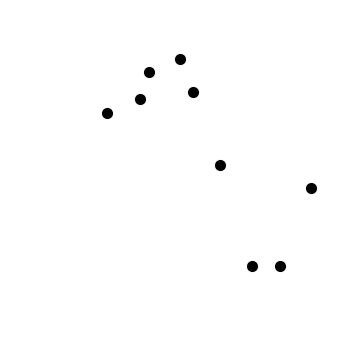
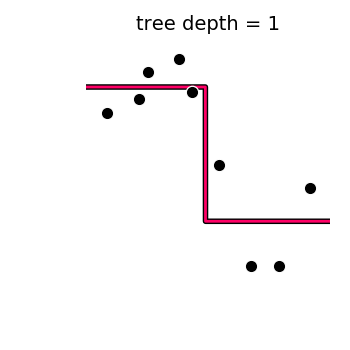
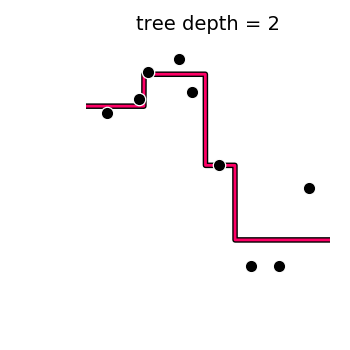
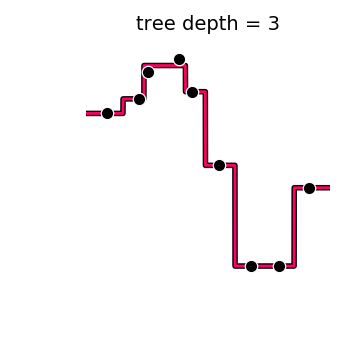
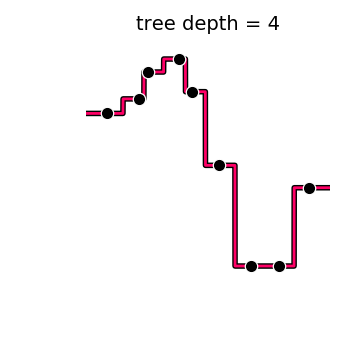
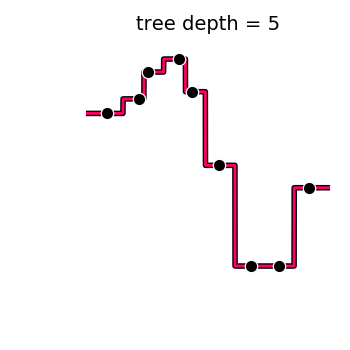

In [27]:
## This code cell will not be shown in the HTML version of this notebook
# create regression tree
csvname = datapath + 'noisy_sin_subsample_2.csv'
depth = 5
tree = nonlib.recursive_tree_lib.RegressionTree.RTree(csvname,depth)

# animate growth
demo = nonlib.recursive_tree_lib.regression_animator.Visualizer(csvname)
frames = depth
demo.animate_trees(tree)

Notice however in this example that in the process of building the tree sometimes, in growing from one depth to the next, *some leaves are not split* - i.e., those leaves *containing just a single datapoint* (e.g, the depth four and depth five trees produce the same result).  Given the way we fit a stump to (any subset of) the data *we have no proper way of fitting a stump to a single datapoint*, since we are using the binary tree to perform nonlinear regression it makes no sense to *split* any part of the input space containing just a single training point (our aim is - after all - to *fit* this data well).  Thus in the recursive process of growing a binary tree *to fit regression data*, if any leaf ever contains just a single datapoint *we do not split the leaf containing it*.  Additionally, if all datapoints contained in the input space of a leaf *have precisely the same output value* there again no reason to split the leaf into two distinct levels, and progress there is halted as well.  We can also see an instance of this in the example below.  Both of these practical conditions are often generalized when implementing tree-based regressors in practice e.g., progress on a leaf is halted if it contains less than a pre-determined number of points (as opposed to just a singleton point).

This means that - in general - binary trees of a defined depth do not often end up 'perfect' in practice, that is where each original leaf is split exactly the same number of times.  Instead certain branches stemming from the root of the tree may halt sooner than others and be uneven in length, with some growing to the defined depth.  Thus when applying binary trees to regression (and - as we will see - classification) we refer to the trees as having a *maximum depth* - the largest depth that a branch of the tree can possibly grow too. 